In [14]:
import tensorflow as tf
import seaborn as sns
import numpy as np

from PIL import Image
import glob
from collections import defaultdict
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
IMG_SIZE = (94, 125)
def pixels_from_path(file_path):
    im = Image.open(file_path)
    
    im = im.resize(IMG_SIZE)
    np_im = np.array(im)
    #matrix of pixel RGB values
    return np_im

In [13]:
glob.glob('cats/*')

[]

In [4]:
shape_counts = defaultdict(int)
for i, cat in enumerate(glob.glob('cats/*')[:1000]):
    if i%100==0:
        print(i)
    img_shape = pixels_from_path(cat).shape
    shape_counts[str(img_shape)]= shape_counts[str(img_shape)]+ 1

In [72]:
shape_items = list(shape_counts.items())
shape_items.sort(key = lambda x: x[1])
shape_items.reverse()

In [3]:
# 10% of the data will automatically be used for validation
validation_size = 0.1
img_size = IMG_SIZE # resize images to be 374x500 (most common shape)
num_channels = 3 # RGB
sample_size = 8192 #We'll use 8192 pictures (2**13)

In [4]:
len(glob.glob('../cats/*'))

12500

In [5]:
pixels_from_path(glob.glob('../cats/*')[5]).shape

(125, 94, 3)

In [6]:
SAMPLE_SIZE = 10240
print("loading training cat images...")
cat_train_set = np.asarray([pixels_from_path(cat) for cat in glob.glob('../cats/*')[:SAMPLE_SIZE]])

loading training cat images...


In [7]:
print("loading training dog images...")
dog_train_set = np.asarray([pixels_from_path(dog) for dog in glob.glob('../dogs/*')[:SAMPLE_SIZE]])

loading training dog images...


In [8]:
valid_size = 2048
print("loading validation cat images...")
cat_valid_set = np.asarray([pixels_from_path(cat) for cat in glob.glob('../cats/*')[-valid_size:]])
print("loading validation dog images...")
dog_valid_set = np.asarray([pixels_from_path(dog) for dog in glob.glob('../dogs/*')[-valid_size:]])

loading validation cat images...
loading validation dog images...


In [9]:
x_train = np.concatenate([cat_train_set, dog_train_set])
labels_train = np.asarray([1 for _ in range(SAMPLE_SIZE)]+[0 for _ in range(SAMPLE_SIZE)])

In [10]:
x_valid = np.concatenate([cat_valid_set, dog_valid_set])
labels_valid = np.asarray([1 for _ in range(valid_size)]+[0 for _ in range(valid_size)])

In [11]:
x_train.shape

(20480, 125, 94, 3)

In [12]:
labels_train.shape

(20480,)

# Run of the Mill MLP

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

total_pixels = img_size[0] *img_size[1] * 3
fc_size = 512

inputs = keras.Input(shape=(img_size[1], img_size[0],3), name='ani_image')
x = layers.Flatten(name = 'flattened_img')(inputs) #turn image to vector.

x = layers.Dense(fc_size, activation='relu', name='first_layer')(x)
outputs = layers.Dense(1, activation='sigmoid', name='class')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

NameError: name 'img_size' is not defined

In [35]:
customAdam = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=customAdam,  # Optimizer
              # Loss function to minimize
              loss="mean_squared_error",
              # List of metrics to monitor
              metrics=["binary_crossentropy","mean_squared_error"])

In [37]:
print('# Fit model on training data')

history = model.fit(x_train, 
                    labels_train,
                    batch_size=32, 
                    shuffle = True, #important since we loaded cats first, dogs second.
                    epochs=10,
                    validation_data=(x_valid, labels_valid))

# Fit model on training data
Train on 4096 samples, validate on 2048 samples
Epoch 1/3
4096/4096 [==============================] - 50s 12ms/sample - loss: 0.5000 - binary_crossentropy: 8.0590 - mean_squared_error: 0.5000 - val_loss: 0.5000 - val_binary_crossentropy: 8.0591 - val_mean_squared_error: 0.5000
Epoch 2/3
4096/4096 [==============================] - 50s 12ms/sample - loss: 0.5000 - binary_crossentropy: 8.0590 - mean_squared_error: 0.5000 - val_loss: 0.5000 - val_binary_crossentropy: 8.0590 - val_mean_squared_error: 0.5000
Epoch 3/3
 256/4096 [>.............................] - ETA: 46s - loss: 0.5312 - binary_crossentropy: 8.5627 - mean_squared_error: 0.5312

KeyboardInterrupt: 

# Single Convolutional Layer

In [15]:
fc_layer_size = 512
img_size = IMG_SIZE

conv_inputs = keras.Input(shape=(img_size[1], img_size[0],3), name='ani_image')
conv_layer = layers.Conv2D(128, kernel_size=3, activation='relu')(conv_inputs)
conv_layer = layers.MaxPool2D(pool_size=(2,2))(conv_layer)
conv_x = layers.Flatten(name = 'flattened_features')(conv_layer) #turn image to vector.

conv_x = layers.Dense(fc_layer_size, activation='relu', name='first_layer')(conv_x)
conv_x = layers.Dense(fc_layer_size, activation='relu', name='second_layer')(conv_x)
conv_outputs = layers.Dense(1, activation='sigmoid', name='class')(conv_x)

conv_model = keras.Model(inputs=conv_inputs, outputs=conv_outputs)

In [16]:
customAdam = keras.optimizers.Adam(lr=1e-6)
conv_model.compile(optimizer=customAdam,  # Optimizer
              # Loss function to minimize
              loss="binary_crossentropy",
              # List of metrics to monitor
              metrics=["binary_crossentropy","mean_squared_error"])

In [17]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)

In [18]:
print('# Fit model on training data')

history = conv_model.fit(x_train, 
                    labels_train, #we pass it th labels
                    #If the model is taking forever to train, make this bigger
                    #If it is taking forever to load for the first epoch, make this smaller
                    batch_size=512, 
                    shuffle = True,
                    epochs=30,
                    # We pass it validation data to
                    # monitor loss and metrics
                    # at the end of each epoch,
                    callbacks = [es],
                    validation_data=(x_valid, labels_valid))

# Fit model on training data
Train on 20480 samples, validate on 4096 samples
Epoch 1/30
20480/20480 [==============================] - 176s 9ms/step - loss: 2.5546 - binary_crossentropy: 2.5546 - mean_squared_error: 0.3867 - val_loss: 1.4289 - val_binary_crossentropy: 1.4289 - val_mean_squared_error: 0.3332
Epoch 2/30
20480/20480 [==============================] - 169s 8ms/step - loss: 1.2083 - binary_crossentropy: 1.2083 - mean_squared_error: 0.3092 - val_loss: 1.1883 - val_binary_crossentropy: 1.1883 - val_mean_squared_error: 0.3154
Epoch 3/30
20480/20480 [==============================] - 167s 8ms/step - loss: 1.0070 - binary_crossentropy: 1.0070 - mean_squared_error: 0.2825 - val_loss: 1.1205 - val_binary_crossentropy: 1.1205 - val_mean_squared_error: 0.3031
Epoch 4/30
20480/20480 [==============================] - 171s 8ms/step - loss: 0.8520 - binary_crossentropy: 0.8520 - mean_squared_error: 0.2543 - val_loss: 1.0210 - val_binary_crossentropy: 1.0210 - val_mean_squared_error: 0

KeyboardInterrupt: 

In [20]:
preds = conv_model.predict(x_valid)
preds = np.asarray([pred[0] for pred in preds])
np.corrcoef(preds, labels_valid)

array([[1.        , 0.38067132],
       [0.38067132, 1.        ]])

In [23]:
conv_model.save('big_cnn_20')

In [21]:
print('hi')

hi


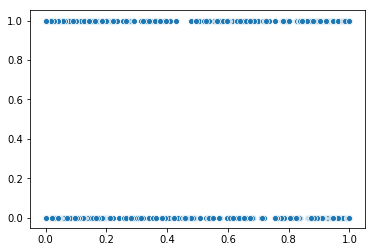

In [42]:
sns.scatterplot(x= preds, y= labels_valid)

In [46]:
cat_quantity = sum(labels_valid)

for i in range(1,10):
    print('threshold :'+str(.1*i))
    print(sum(labels_valid[preds > .1*i])/labels_valid[preds > .1*i].shape[0])

threshold :0.1
0.554140127388535
threshold :0.2
0.5587188612099644
threshold :0.30000000000000004
0.5632183908045977
threshold :0.4
0.5705521472392638
threshold :0.5
0.5817409766454352
threshold :0.6000000000000001
0.5779816513761468
threshold :0.7000000000000001
0.581453634085213
threshold :0.8
0.5842391304347826
threshold :0.9
0.6114649681528662


In [55]:
print(preds.mean())
print(preds[labels_valid == 0].mean())
print(preds[labels_valid == 1].mean())

0.45573586
0.39048657
0.5209851


# Bigger Convolutional Model

In [64]:
fc_layer_size = 256
img_size = IMG_SIZE

conv_inputs = keras.Input(shape=(img_size[1], img_size[0],3), name='ani_image')
conv_layer = layers.Conv2D(48, kernel_size=3, activation='relu')(conv_inputs)
conv_layer = layers.MaxPool2D(pool_size=(2,2))(conv_layer)

conv_layer = layers.Conv2D(48, kernel_size=3, activation='relu')(conv_layer)
conv_layer = layers.MaxPool2D(pool_size=(2,2))(conv_layer)

conv_x = layers.Flatten(name = 'flattened_features')(conv_layer) #turn image to vector.

conv_x = layers.Dense(fc_layer_size, activation='relu', name='first_layer')(conv_x)
conv_x = layers.Dense(fc_layer_size, activation='relu', name='second_layer')(conv_x)
conv_outputs = layers.Dense(1, activation='sigmoid', name='class')(conv_x)

conv_model = keras.Model(inputs=conv_inputs, outputs=conv_outputs)

In [65]:
customAdam = keras.optimizers.Adam(lr=1e-6)
conv_model.compile(optimizer=customAdam,  # Optimizer
              # Loss function to minimize
              loss="binary_crossentropy",
              # List of metrics to monitor
              metrics=["binary_crossentropy","mean_squared_error"])

In [67]:
print('# Fit model on training data')

history = conv_model.fit(x_train, 
                    labels_train, #we pass it th labels
                    #If the model is taking forever to train, make this bigger
                    #If it is taking forever to load for the first epoch, make this smaller
                    batch_size=64, 
                    shuffle = True,
                    epochs=15,
                    # We pass it validation data to
                    # monitor loss and metrics
                    # at the end of each epoch
                    validation_data=(x_valid, labels_valid))

# Fit model on training data
Train on 4096 samples, validate on 1024 samples
Epoch 1/15
4096/4096 [==============================] - 154s 38ms/sample - loss: 2.6895 - binary_crossentropy: 2.6895 - mean_squared_error: 0.4217 - val_loss: 2.4423 - val_binary_crossentropy: 2.4423 - val_mean_squared_error: 0.4087
Epoch 2/15
4096/4096 [==============================] - 141s 35ms/sample - loss: 2.1405 - binary_crossentropy: 2.1405 - mean_squared_error: 0.3881 - val_loss: 2.2096 - val_binary_crossentropy: 2.2096 - val_mean_squared_error: 0.3880
Epoch 3/15
4096/4096 [==============================] - 144s 35ms/sample - loss: 1.8134 - binary_crossentropy: 1.8134 - mean_squared_error: 0.3636 - val_loss: 1.9511 - val_binary_crossentropy: 1.9511 - val_mean_squared_error: 0.3665
Epoch 4/15
4096/4096 [==============================] - 145s 35ms/sample - loss: 1.6297 - binary_crossentropy: 1.6297 - mean_squared_error: 0.3433 - val_loss: 1.8383 - val_binary_crossentropy: 1.8383 - val_mean_squared_error

In [68]:
preds = conv_model.predict(x_valid)
preds = np.asarray([pred[0] for pred in preds])
np.corrcoef(preds, labels_valid)

array([[1.       , 0.2188213],
       [0.2188213, 1.       ]])

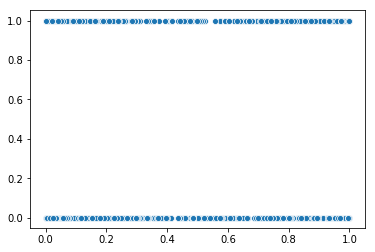

In [69]:
sns.scatterplot(x= preds, y= labels_valid)

In [70]:
print(preds.mean())
print(preds[labels_valid == 0].mean())
print(preds[labels_valid == 1].mean())

0.61730576
0.53210735
0.7025041


In [71]:
cat_quantity = sum(labels_valid)

for i in range(1,10):
    print('threshold :'+str(.1*i))
    print(sum(labels_valid[preds > .1*i])/labels_valid[preds > .1*i].shape[0])

threshold :0.1
0.5424757281553398
threshold :0.2
0.551948051948052
threshold :0.30000000000000004
0.5563282336578581
threshold :0.4
0.565406976744186
threshold :0.5
0.5712074303405573
threshold :0.6000000000000001
0.5881383855024712
threshold :0.7000000000000001
0.5940246045694201
threshold :0.8
0.5988372093023255
threshold :0.9
0.6168674698795181


In [11]:
def animal_pic(index):
    return Image.fromarray(x_valid[index])
def cat_index(index):
    return conv_model.predict(np.asarray([x_valid[124]]))[0][0]

In [108]:
conv_model.save('conv_model_big')

probability of being a cat: 0.046173080801963806


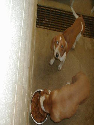

In [107]:
index = 600
print("probability of being a cat: {}".format(cat_index(index)))
animal_pic(index)

In [96]:
conv_model.predict(np.asarray([x_valid[124]]))[0][0]

0.04617308

In [110]:
big_model = keras.models.load_model('conv_model_big')

# Huge Model

In [111]:
fc_layer_size = 512
img_size = IMG_SIZE

conv_inputs = keras.Input(shape=(img_size[1], img_size[0],3), name='ani_image')
conv_layer = layers.Conv2D(256, kernel_size=3, activation='relu')(conv_inputs)
conv_layer = layers.MaxPool2D(pool_size=(2,2))(conv_layer)

conv_layer = layers.Conv2D(256, kernel_size=3, activation='relu')(conv_layer)
conv_layer = layers.MaxPool2D(pool_size=(2,2))(conv_layer)

conv_x = layers.Flatten(name = 'flattened_features')(conv_layer) #turn image to vector.

conv_x = layers.Dense(fc_layer_size, activation='relu', name='first_layer')(conv_x)
conv_x = layers.Dense(fc_layer_size, activation='relu', name='second_layer')(conv_x)
conv_outputs = layers.Dense(1, activation='sigmoid', name='class')(conv_x)

huge_conv_model = keras.Model(inputs=conv_inputs, outputs=conv_outputs)

In [113]:
customAdam = keras.optimizers.Adam(lr=1e-6)
huge_conv_model.compile(optimizer=customAdam,  # Optimizer
              # Loss function to minimize
              loss="binary_crossentropy",
              # List of metrics to monitor
              metrics=["binary_crossentropy","mean_squared_error"])

In [120]:
print('# Fit model on training data')

history = huge_conv_model.fit(x_train, 
                    labels_train, #we pass it th labels
                    #If the model is taking forever to train, make this bigger
                    #If it is taking forever to load for the first epoch, make this smaller
                    batch_size=64, 
                    shuffle = True,
                    epochs=5,
                    # We pass it validation data to
                    # monitor loss and metrics
                    # at the end of each epoch
                    validation_data=(x_valid, labels_valid))

# Fit model on training data
Train on 4096 samples, validate on 1024 samples
Epoch 1/5
4096/4096 [==============================] - 450s 110ms/sample - loss: 0.6818 - binary_crossentropy: 0.6818 - mean_squared_error: 0.2141 - val_loss: 1.1085 - val_binary_crossentropy: 1.1085 - val_mean_squared_error: 0.3099
Epoch 2/5
4096/4096 [==============================] - 445s 109ms/sample - loss: 0.6629 - binary_crossentropy: 0.6629 - mean_squared_error: 0.2085 - val_loss: 0.9474 - val_binary_crossentropy: 0.9474 - val_mean_squared_error: 0.2804
Epoch 3/5
4096/4096 [==============================] - 445s 109ms/sample - loss: 0.6142 - binary_crossentropy: 0.6142 - mean_squared_error: 0.1947 - val_loss: 0.9234 - val_binary_crossentropy: 0.9234 - val_mean_squared_error: 0.2764
Epoch 4/5
4096/4096 [==============================] - 449s 110ms/sample - loss: 0.5687 - binary_crossentropy: 0.5687 - mean_squared_error: 0.1805 - val_loss: 0.8957 - val_binary_crossentropy: 0.8957 - val_mean_squared_error

In [121]:
preds = huge_conv_model.predict(x_valid)
preds = np.asarray([pred[0] for pred in preds])
np.corrcoef(preds, labels_valid)

array([[1.        , 0.30370386],
       [0.30370386, 1.        ]])

In [122]:
print(preds.mean())
print(preds[labels_valid == 0].mean())
print(preds[labels_valid == 1].mean())

0.529647
0.4221822
0.6371118


In [123]:
cat_quantity = sum(labels_valid)

for i in range(1,10):
    print('threshold :'+str(.1*i))
    print(sum(labels_valid[preds > .1*i])/labels_valid[preds > .1*i].shape[0])

threshold :0.1
0.544589774078478
threshold :0.2
0.5773889636608345
threshold :0.30000000000000004
0.5922619047619048
threshold :0.4
0.6088379705400983
threshold :0.5
0.6314814814814815
threshold :0.6000000000000001
0.6376811594202898
threshold :0.7000000000000001
0.6484560570071259
threshold :0.8
0.6676300578034682
threshold :0.9
0.6907630522088354


In [125]:
huge_conv_model.save('conv_model_huge_e13')

In [10]:
big_model = keras.models.load_model('conv_model_huge_e13')

In [12]:
preds = big_model.predict(x_valid)
preds = np.asarray([pred[0] for pred in preds])

In [15]:
sum(labels_valid)

512

In [30]:
for i in range(1,10):
    t = .1*i
    print("{:.1f}:".format(t))
    tp = (preds > t)&(labels_valid==1)
    tn = (preds <= t)&(labels_valid==0)
    print(np.sum(np.where(tp|tn, 1, 0))/1024.)

0.1:
0.5732421875
0.2:
0.6123046875
0.3:
0.62109375
0.4:
0.6298828125
0.5:
0.638671875
0.6:
0.6298828125
0.7:
0.6220703125
0.8:
0.61328125
0.9:
0.5927734375


In [37]:
print('# Fit model on training data')

history = big_model.fit(x_train, 
                    labels_train, #we pass it th labels
                    #If the model is taking forever to train, make this bigger
                    #If it is taking forever to load for the first epoch, make this smaller
                    batch_size=64, 
                    shuffle = True,
                    epochs=10,
                    # We pass it validation data to
                    # monitor loss and metrics
                    # at the end of each epoch
                    validation_data=(x_valid, labels_valid))

# Fit model on training data
Train on 4096 samples, validate on 1024 samples
Epoch 1/10
4096/4096 [==============================] - 529s 129ms/sample - loss: 0.6078 - binary_crossentropy: 0.6078 - mean_squared_error: 0.1951 - val_loss: 0.8654 - val_binary_crossentropy: 0.8654 - val_mean_squared_error: 0.2635
Epoch 2/10
4096/4096 [==============================] - 445s 109ms/sample - loss: 0.4972 - binary_crossentropy: 0.4972 - mean_squared_error: 0.1597 - val_loss: 0.8496 - val_binary_crossentropy: 0.8496 - val_mean_squared_error: 0.2578
Epoch 3/10
4096/4096 [==============================] - 446s 109ms/sample - loss: 0.4481 - binary_crossentropy: 0.4481 - mean_squared_error: 0.1429 - val_loss: 0.8247 - val_binary_crossentropy: 0.8247 - val_mean_squared_error: 0.2499
Epoch 4/10
4096/4096 [==============================] - 445s 109ms/sample - loss: 0.4042 - binary_crossentropy: 0.4042 - mean_squared_error: 0.1280 - val_loss: 0.8713 - val_binary_crossentropy: 0.8713 - val_mean_squared_e

KeyboardInterrupt: 

In [38]:
preds = big_model.predict(x_valid)
preds = np.asarray([pred[0] for pred in preds])
for i in range(1,10):
    t = .1*i
    print("{:.1f}:".format(t))
    tp = (preds > t)&(labels_valid==1)
    tn = (preds <= t)&(labels_valid==0)
    print(np.sum(np.where(tp|tn, 1, 0))/1024.)

0.1:
0.5810546875
0.2:
0.630859375
0.3:
0.6416015625
0.4:
0.6572265625
0.5:
0.6689453125
0.6:
0.6767578125
0.7:
0.6572265625
0.8:
0.6513671875
0.9:
0.62890625


In [40]:
big_model.save('conv_model_big_e19')